In [5]:
import matplotlib.pyplot as plt
import numpy as np

#### Spreading of Fire

* In many simulations, we model a dynamic area under consideration with an $n\times n$ grid, or lattice

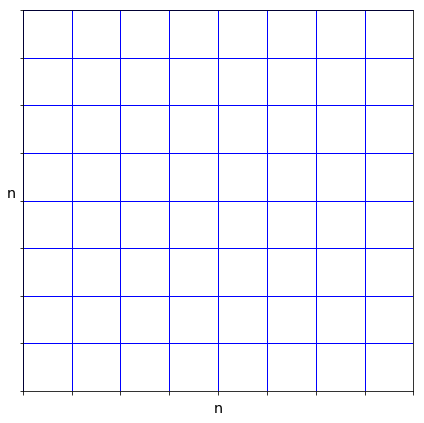

In [15]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.grid(linestyle="-", color="b", lw=1)
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel("n", fontsize="x-large")
ax.set_ylabel("n", fontsize="x-large", rotation="horizontal");
plt.show();

* Each cell in the lattice contains a characteristic of a corresponding location
 - These are called **states**
* E.g., in a simulation of the spread a fire a cell may be 0, 1, or 2
* This could indicate an empty cell, a cell with a non-burning tree, or a cell with a burning tree
* This is an example of a discrete, stochastic system
* The system needs two probabilities
  - `prob_tree` - probability that a tree initially occupies a site. The density of the grid as %.
  - `prob_burning` If a site has a tree, probability that a tree is burning when the simulation begins
* Use these probabilities to initialize a grid

In [16]:
def init_grid(n, prob_tree, prob_burning):
    lattice = np.random.binomial(n=1, p=prob_tree, size=(n,n))
    lattice *= np.random.binomial(n=1, p=prob_burning, size=(n,n)) + 1
    return lattice

In [17]:
grid = init_grid(50, .8, .0005)

In [18]:
from matplotlib import colors
color_map = colors.ListedColormap(["white", "gray", "red"])
bounds = [0, 1, 2, 3]
norm = colors.BoundaryNorm(bounds, color_map.N)

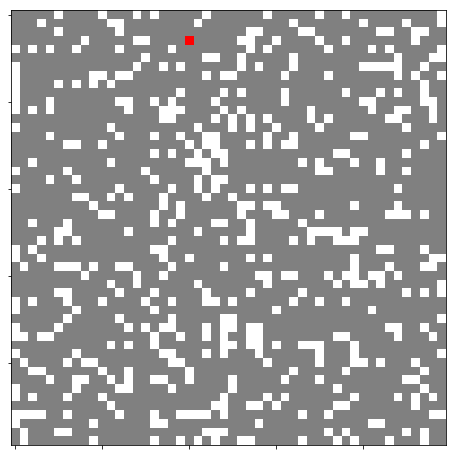

In [19]:
fig, ax = plt.subplots(figsize=(8,8))

ax.imshow(grid, interpolation='none', cmap=color_map, 
          norm=norm)
ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([]);
plt.show();

#### Updating Rules

* At each iteration, we apply a function `spread` to each site to determin its value
* The cell value at the next instant depends on
  - its current value
  - the values of its **neighbors** to the North, South, East, and West
* So `spread` needs five arguments -- site, N, S, E, and W
* Sites diagonal to the site do not affect a site's value during iterations
* The cells to the north, east, south, and west and the site itself are called the **von Neumann neighborhood** of a site

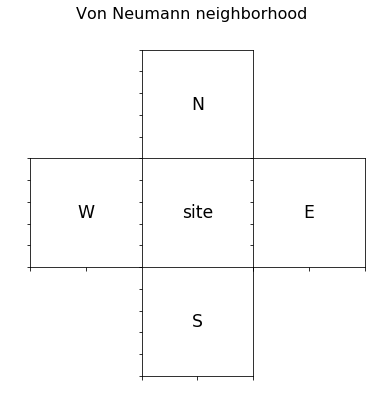

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6,6))
axes[0,0].set_axis_off()
axes[0,2].set_axis_off()
axes[2,0].set_axis_off()
axes[2,2].set_axis_off()
fig.subplots_adjust(wspace=0, hspace=0)
text = {(0,1) : "N",
        (1,0) : "W",
        (1,1) : "site",
        (1,2) : "E",
        (2,1) : "S"
        }
for grid in [(0,1), (1,0), (1,1), (1,2), (2,1)]:
    ax = axes[grid[0], grid[1]]
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.text(.5, .5, text[grid], 
            horizontalalignment="center", 
            verticalalignment="center",
            fontsize="xx-large")
fig.suptitle("Von Neumann neighborhood", fontsize=16);
plt.show();

* We need two additional probabilities to complete the `spread` function
* `prob_immune` - The probability of immunity from catching fire
  - This can be determined by real conditions such as the dry weather
* `prob_lightning` - The probability of lightning hitting a site
* Thus a tree might catch fire because a neighbor is burning or due to a lightning strike

**Aside** reshaping arrays.

In [21]:
sub_array = np.arange(1, 10).reshape((3,3))

In [22]:
sub_array

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [23]:
sub_array.flatten()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [24]:
sub_array.ravel()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [25]:
sub_array.flatten()[1::2]

array([2, 4, 6, 8])

**Aside** the any function/method

In [26]:
np.any(np.array([True, False]))

True

In [27]:
np.any(np.array([False, False]))

False

In [28]:
np.any(np.array([0,0]))

False

In [29]:
np.any(np.array([1,0]))

True

In [30]:
np.any(np.array([2,2]))

True

* What happens at a site on the next iteration is determined by a number of things
* **1)** If this site is already burning, then the tree burns down and is now an empty site
* **2)** If any neighbors are burning, then the fire may spread
  - If a site as `prob_immune`, then the probability of catching fire is `1 - prob_immune`
* **3)** A tree can also catch on fire if is struck by lightning with probability `prob_lightning`
  - However, a tree may not burn if struck with probability `prob_immune`
  - The probability that a tree gets struch by lightning AND catches on fire is
  - `prob_lightning x (1 - prob_immune)`

In [31]:
np.random.seed(12345)
sample_small_grid = init_grid(3, prob_tree=.8, prob_burning=.4) 
sample_small_grid

array([[0, 2, 2],
       [1, 1, 1],
       [0, 2, 2]])

In [32]:
def spread(small_grid, prob_lightning, prob_immune):
    """
    small_grid is a 3x3 array
    """
    # no tree or burned down
    if (small_grid[1,1] == 2 or 
        small_grid[0,0] == 0):
        return 0
    # any neighbors are burning
    if ((small_grid.flatten()[1::2] == 2).any() and 
         # it's burning now
         np.binomial(1, 1 - prob_immune)): 
        return 2
    
    # it hasn't caught fire yet
    if np.binomial(1, (1 - prob_immune)*prob_lightning):
        return 2
        
    return 1
    

#### Periodic Boundary Conditions

* `spread` takes arguments for N, S, E, and W
* The values on the edges of our grid do not have neighbors outside the bounds
* We can extend the grid by one cell to take care of this
* Several choices exist for what avlue to give to those cells
  - **Absorbing boundary conditions** Each boundary cell is EMPTY. The boundary insulates.
  - Give each boundary cell the value of its immediate neighbor
  - **Periodic boundary conditions** Wrap north-south values and the east-west values like a torus
* We will use **periodic boundary conditions** so that one boundary affects its opposite boundary cells

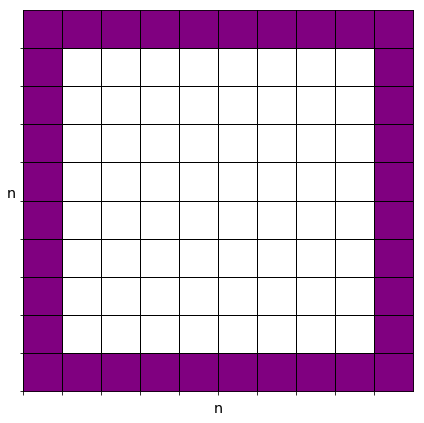

In [33]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.grid(linestyle="-", color="k", lw=1, )
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel("n", fontsize="x-large")
ax.set_ylabel("n", fontsize="x-large", rotation="horizontal");
ax.set_axisbelow(False)
ax.fill_between(range(11), 0, 1, color="purple")
ax.fill_between(range(11), 9, 10, color="purple")
ax.fill_betweenx(range(11), 0, 1, color="purple")
ax.fill_betweenx(range(11), 9, 10, color="purple");
plt.show();

**Aside** N-D moving windows using scipy

In [34]:
from scipy import ndimage

In [35]:
sample_array = np.arange(1,10).reshape(3,3)

In [37]:
print(sample_array)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


In [38]:
def func_to_apply(grid):
    #print grid
    #print grid.reshape(3,3)
    return grid[1]

In [39]:
ndimage.generic_filter(sample_array, func_to_apply, size=3, 
                       mode='wrap')

array([[7, 8, 9],
       [1, 2, 3],
       [4, 5, 6]])

In [40]:
np.random.seed(12345)
sample_small_grid = init_grid(4, prob_tree=.8, prob_burning=.4) 
sample_small_grid

array([[0, 2, 2, 2],
       [2, 2, 0, 1],
       [1, 2, 2, 0],
       [2, 1, 1, 2]])

* Take point (1, 1)
* What is the state of this site?
* In writing out spread function, it will take the surrounding submatrix

In [41]:
sample_small_grid[:3, :3]

array([[0, 2, 2],
       [2, 2, 0],
       [1, 2, 2]])

* As we saw above, however, it will get a raveled or flattened version of this array

In [42]:
sample_small_grid[:3, :3].flatten()

array([0, 2, 2, 2, 2, 0, 1, 2, 2])

In [43]:
def spread(small_grid, prob_lightning, prob_immune):
    """
    small_grid is a flattened 3x3 array
    """
    # no tree or burned down
    if (small_grid[4] == 2 or small_grid[4] == 0):
        return 0
    # any neighbors are burning
    elif ((small_grid[1::2] == 2).any() and 
         # it's burning now
         np.random.binomial(1, 1 - prob_immune)): 
        return 2
    # it hasn't caught fire yet
    elif np.random.binomial(1, (1 - prob_immune)*prob_lightning):
        return 2
    else:    
        return 1

In [44]:
def simulate_fire(n, prob_tree, prob_burning, prob_lightning, 
                  prob_immune, t):
    grids = []
    grid = init_grid(n, prob_tree, prob_burning)
    grids.append(grid)
    for i in range(t):
        new_grid = np.zeros_like(grid)
        ndimage.generic_filter(grids[-1], spread, size=3, mode="wrap", 
                               output=new_grid, 
                               extra_arguments=(prob_lightning,
                                                prob_immune))
        grids.append(new_grid.copy())
    return grids

In [45]:
np.random.seed(12345)
simulated_fire = simulate_fire(50, .8, .0005, .00001, .25, 50)

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


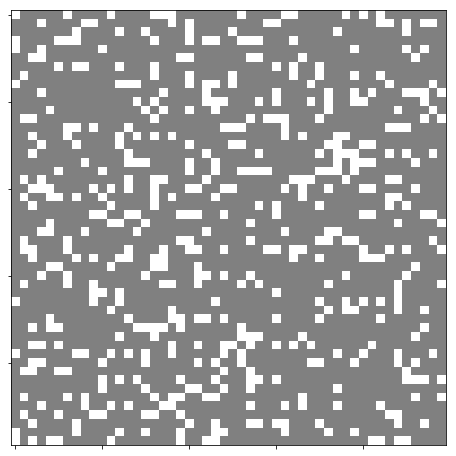

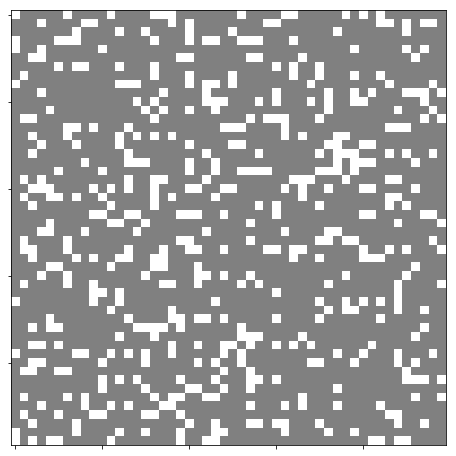

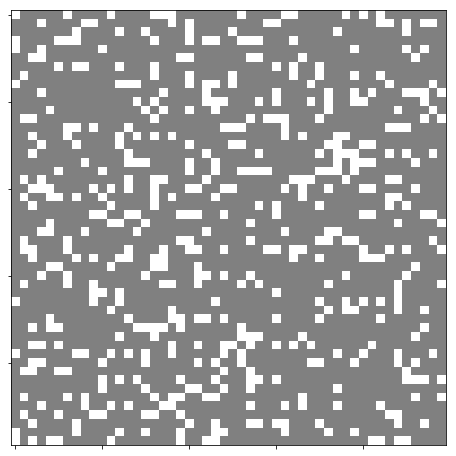

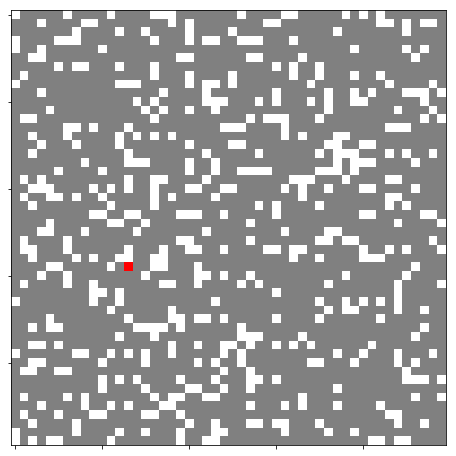

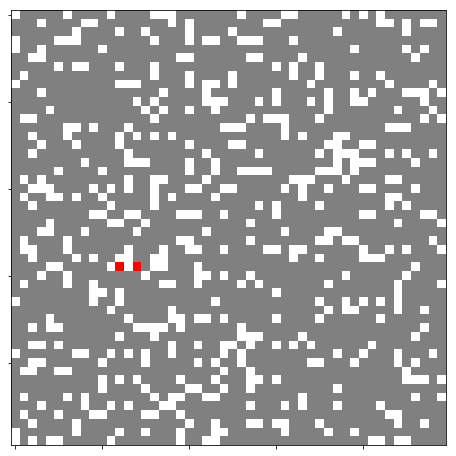

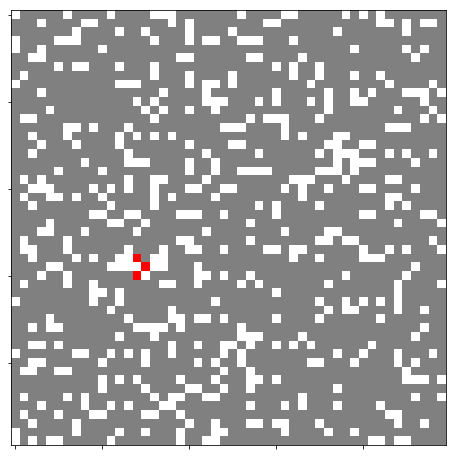

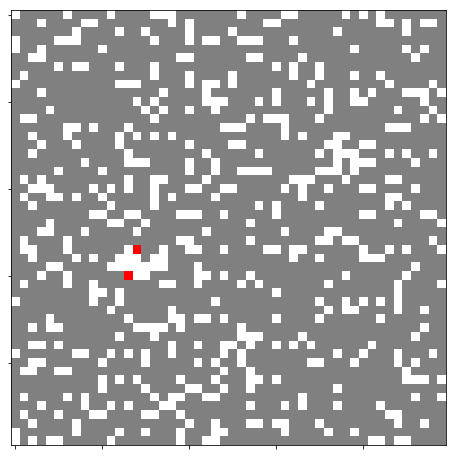

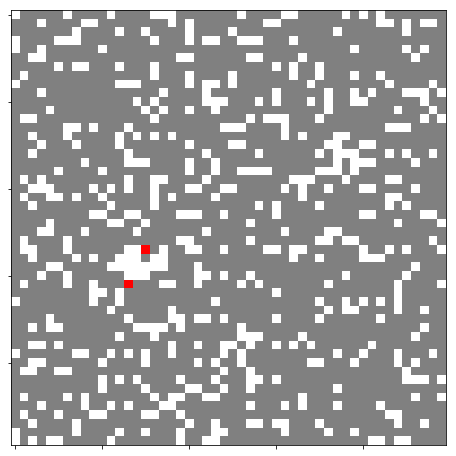

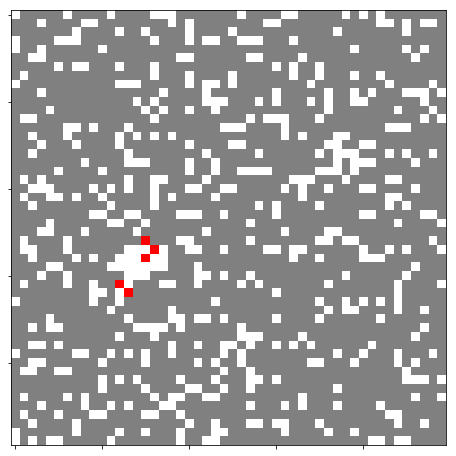

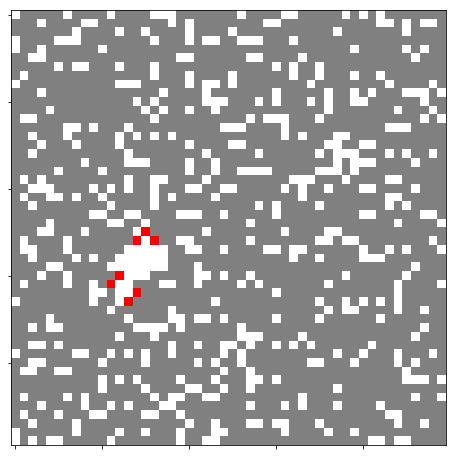

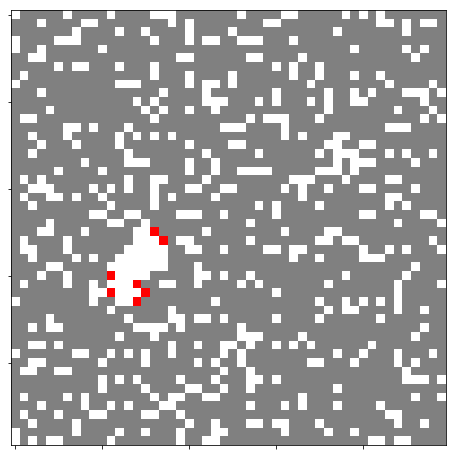

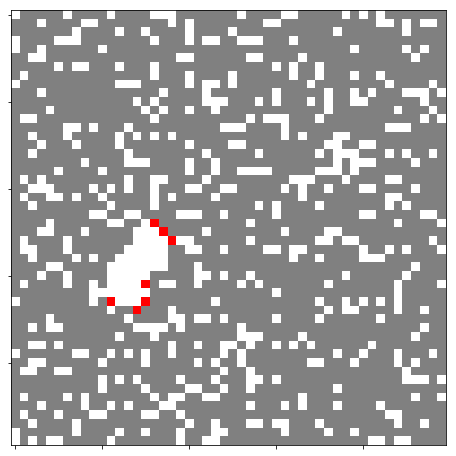

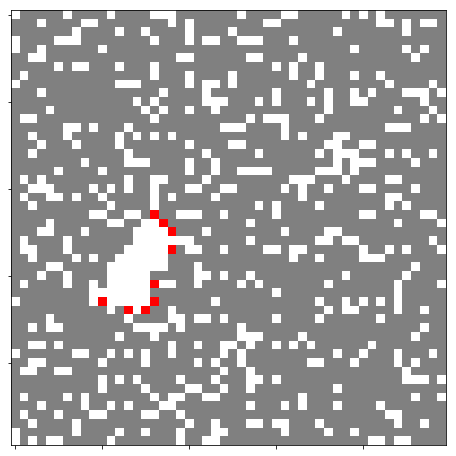

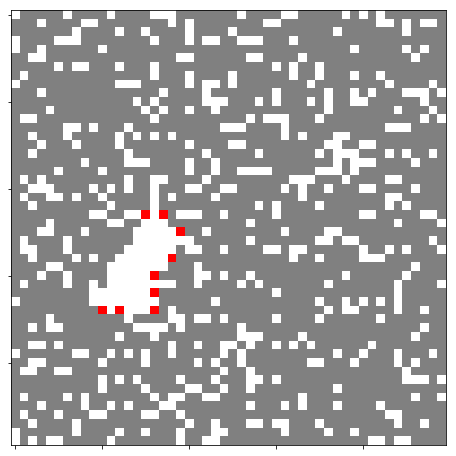

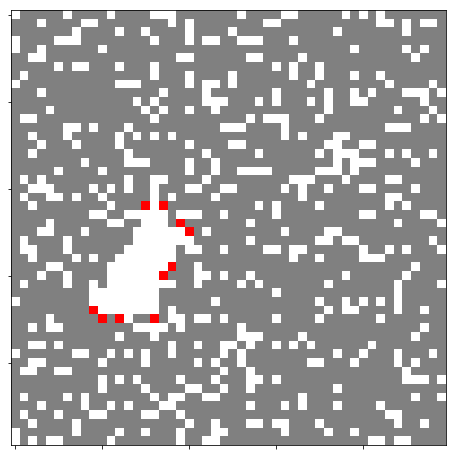

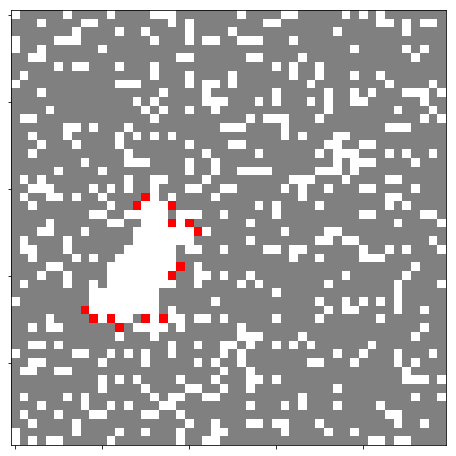

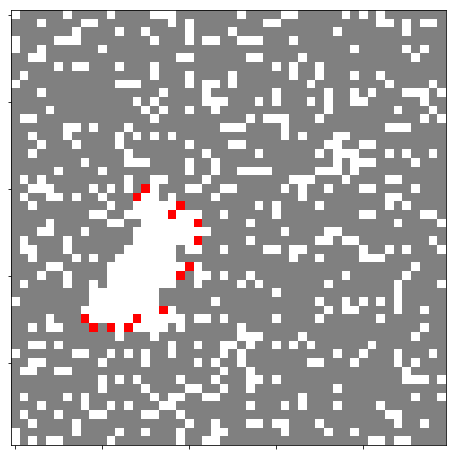

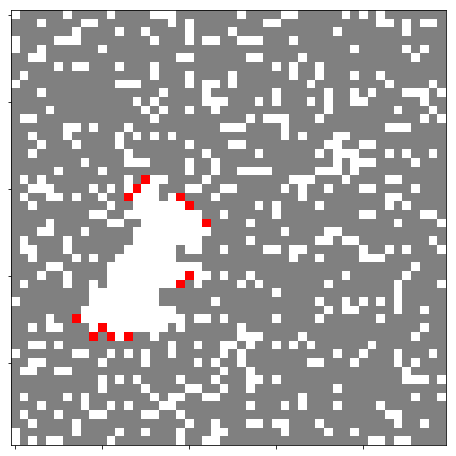

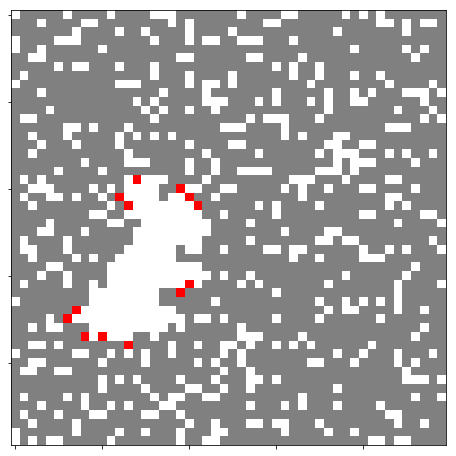

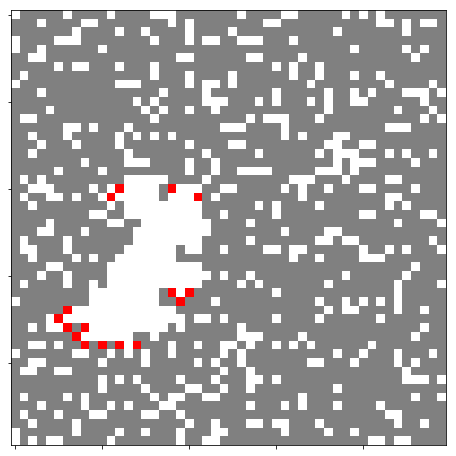

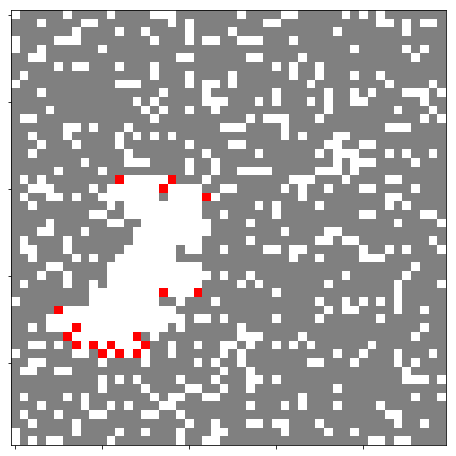

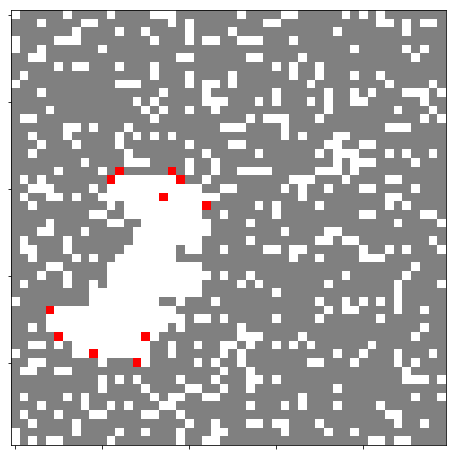

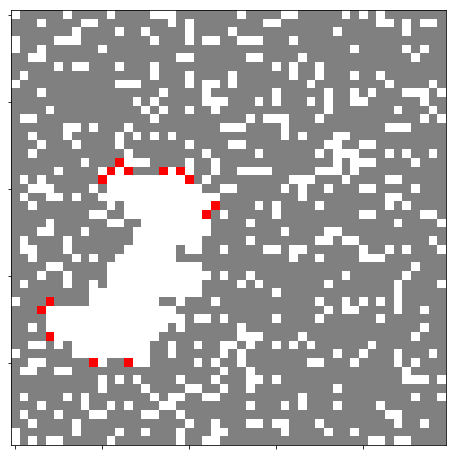

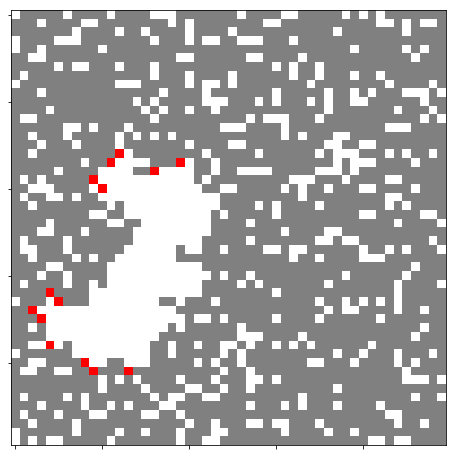

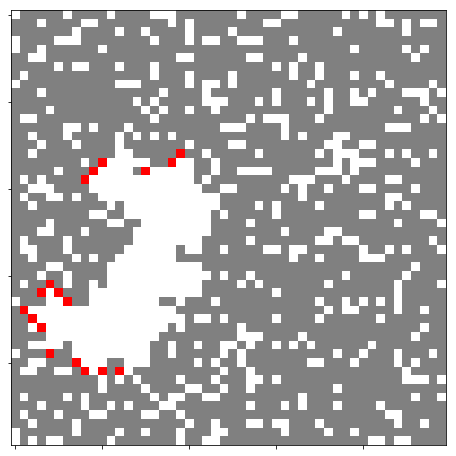

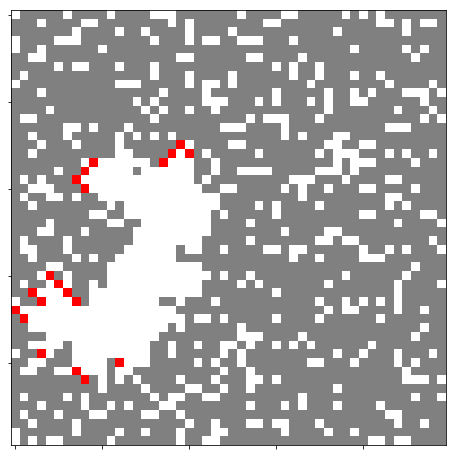

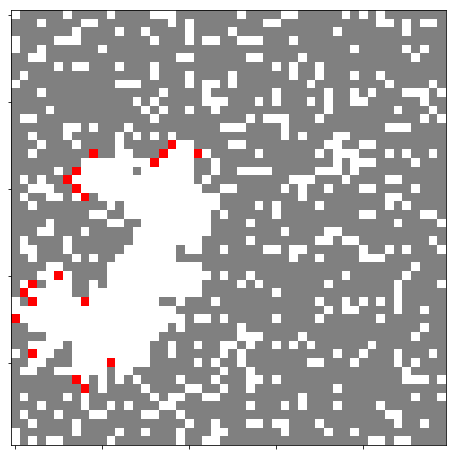

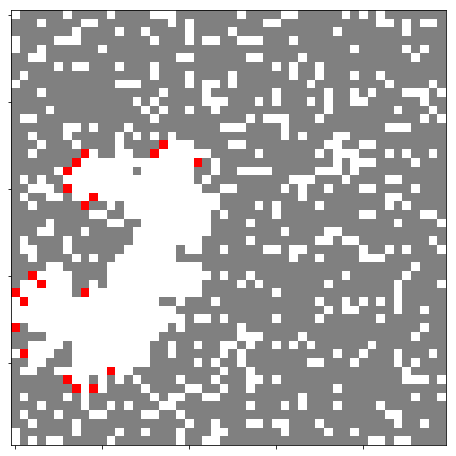

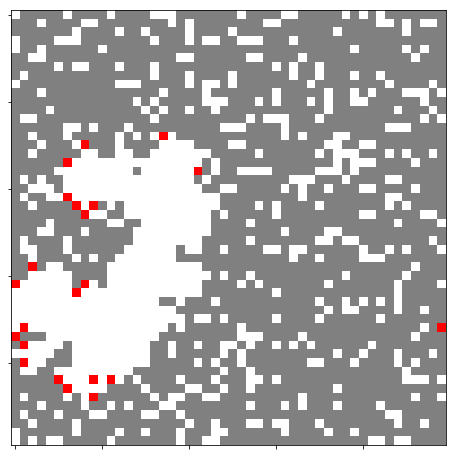

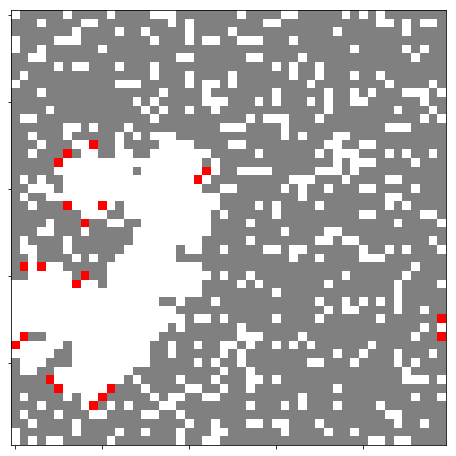

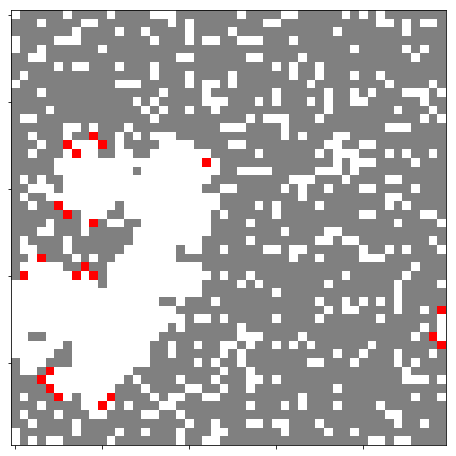

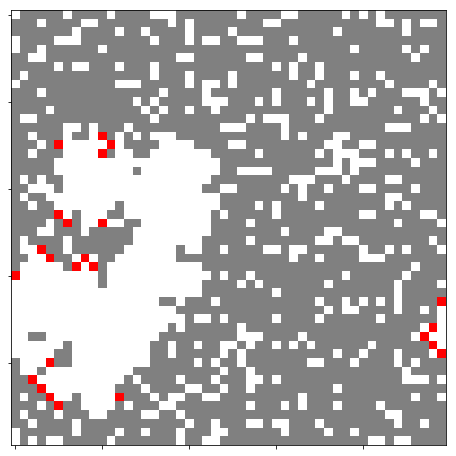

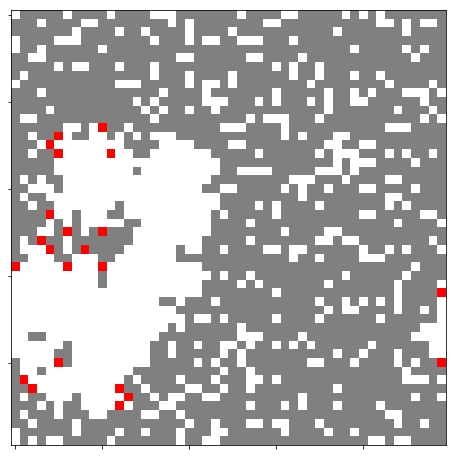

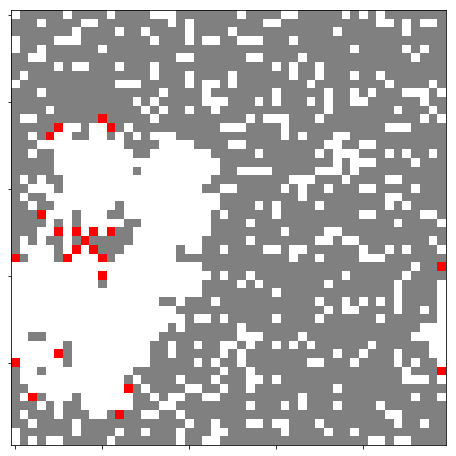

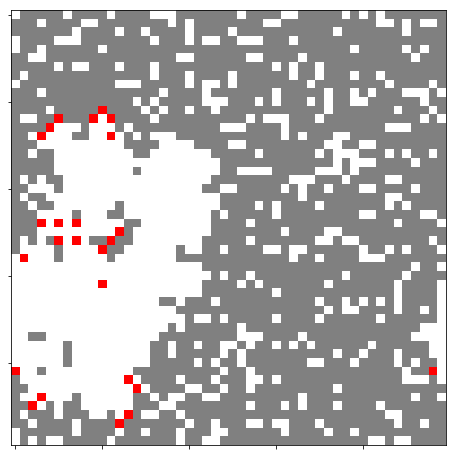

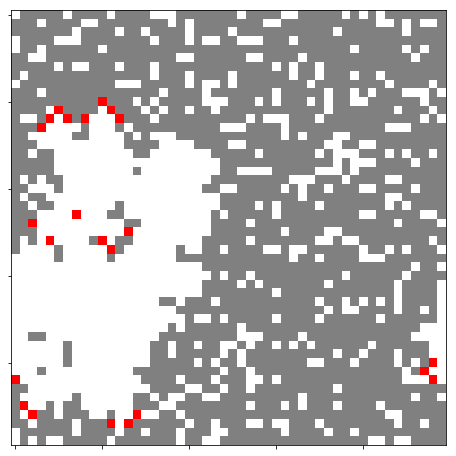

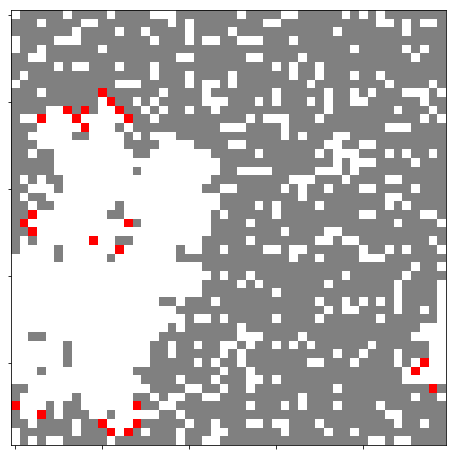

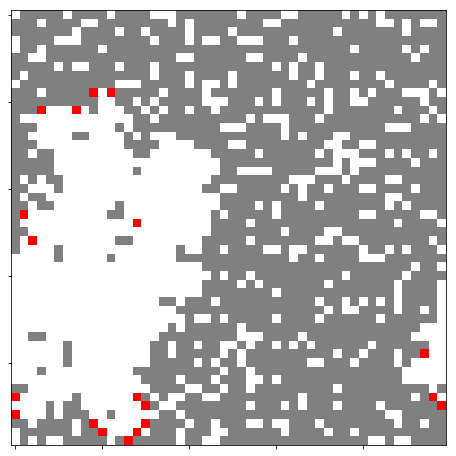

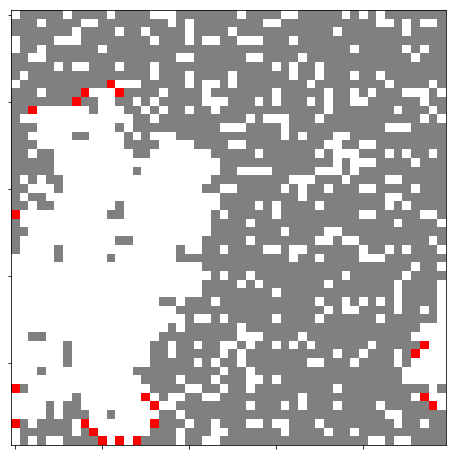

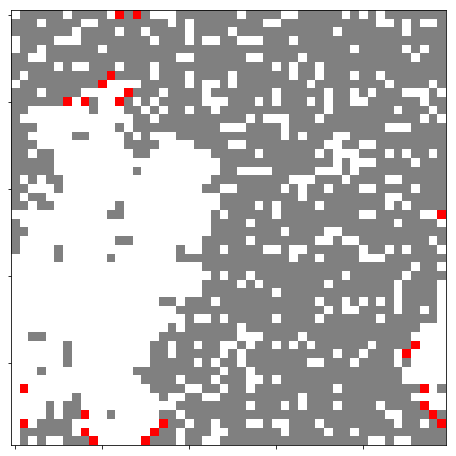

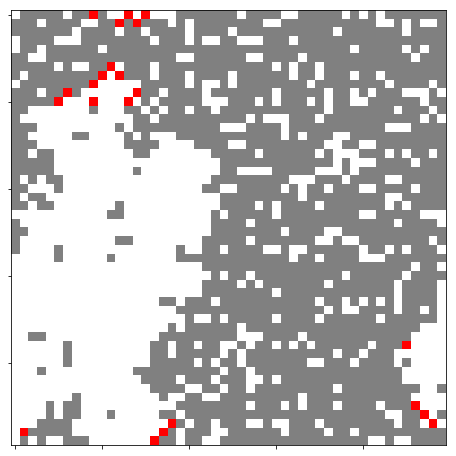

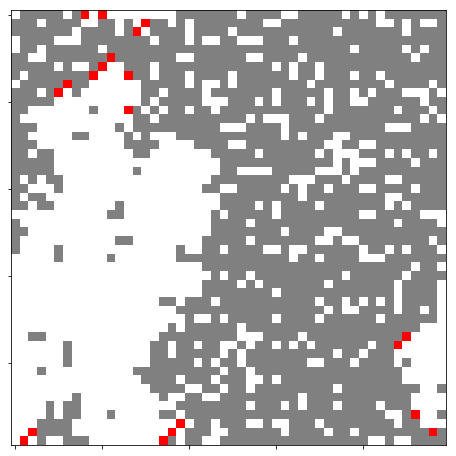

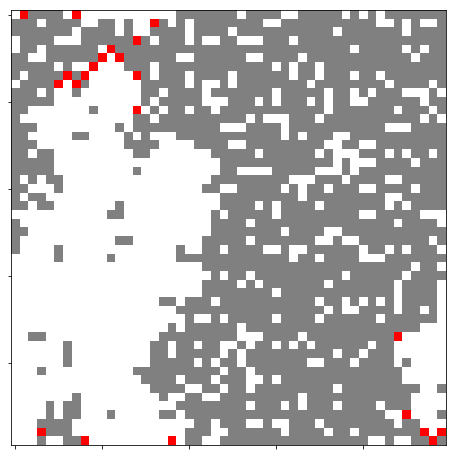

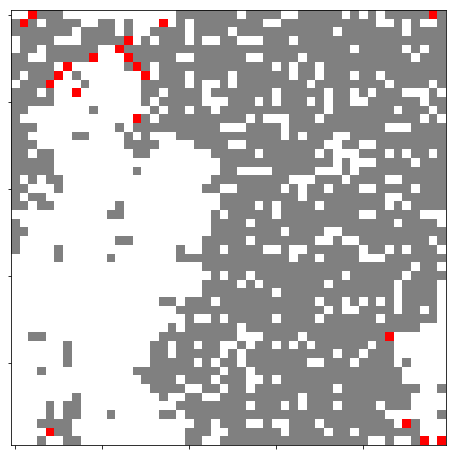

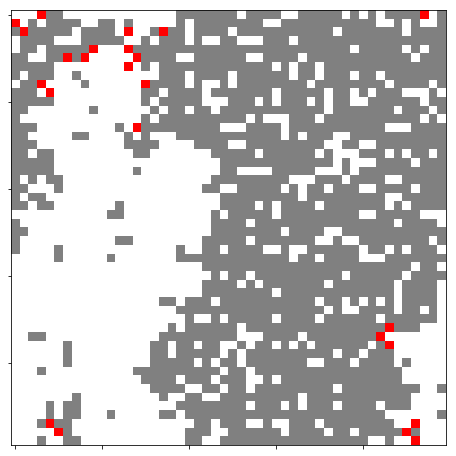

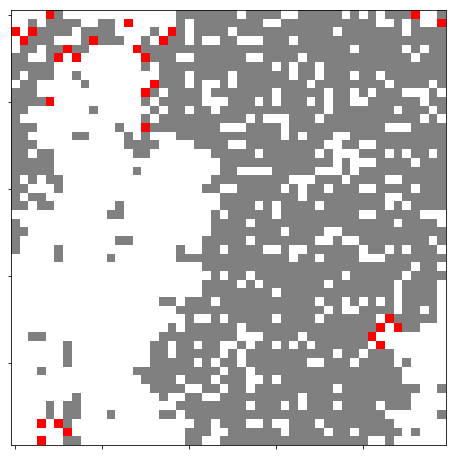

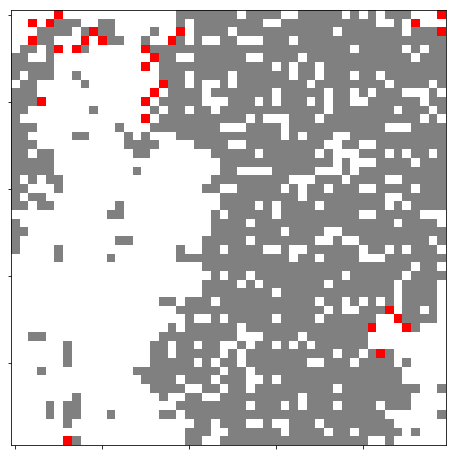

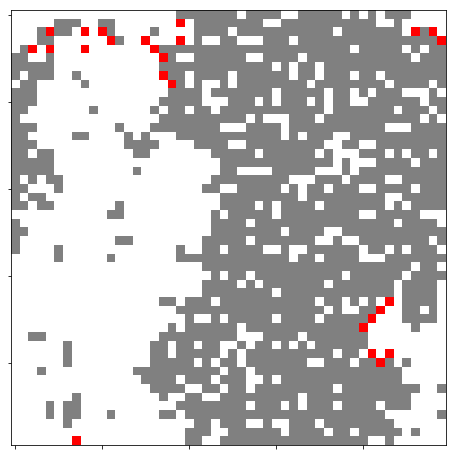

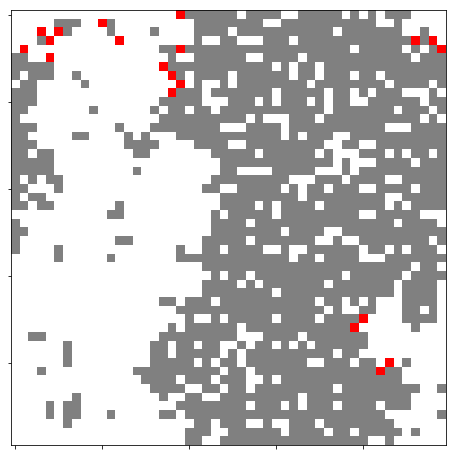

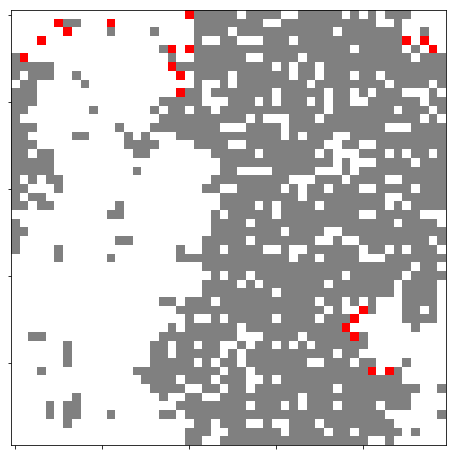

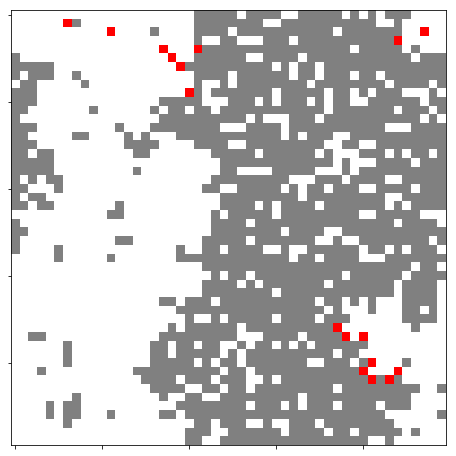

In [47]:
for i, fire in enumerate(simulated_fire):
    fig, ax = plt.subplots(figsize=(8,8))
    # pcolor
    ax.imshow(fire, interpolation='none', cmap=color_map, 
              norm=norm)
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([]);
    fig.savefig("fire_animate%02d.png" % i)
plt.show();

In [49]:
#!rm animated_fire.webm

In [51]:
!ffmpeg -f image2 -r 1/2 -i fire_animate%02d.png -r 30 animated_fire.avi

ffmpeg version 3.3.1 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 8.1.0 (clang-802.0.42)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/3.3.1 --enable-shared --enable-pthreads --enable-gpl --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --disable-lzma --enable-vda
  libavutil      55. 58.100 / 55. 58.100
  libavcodec     57. 89.100 / 57. 89.100
  libavformat    57. 71.100 / 57. 71.100
  libavdevice    57.  6.100 / 57.  6.100
  libavfilter     6. 82.100 /  6. 82.100
  libavresample   3.  5.  0 /  3.  5.  0
  libswscale      4.  6.100 /  4.  6.100
  libswresample   2.  7.100 /  2.  7.100
  libpostproc    54.  5.100 / 54.  5.100
Input #0, image2, from 'fire_animate%02d.png':
  Duration: 00:01:42.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 576x576 [SAR 2834:2834 DAR 1:1], 0.50 fps, 0.50 tbr, 0.50 tb